I'm going to come back and see if I can clean up the code a bit but I basically just modified something online.


In [ ]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder


data_url = 'https://github.gatech.edu/raw/asyeda7/ML_Group_13/main/mxmh_survey_results.csv?token=GHSAT0AAAAAAAADBKBQKJTPDDSXMER7MXFEZRECF6Q'
df = pd.read_csv(data_url)

columns = [
    'Hours per day',
    'While working',
    'Instrumentalist',
    'Composer',
    'Exploratory',
    'Foreign languages',
    'BPM',
    'Frequency [Country]',
    'Frequency [EDM]',
    'Frequency [Folk]',
    'Frequency [Gospel]',
    'Frequency [Hip hop]',
    'Frequency [Jazz]',
    'Frequency [K pop]',
    'Frequency [Latin]',
    'Frequency [Lofi]',
    'Frequency [Metal]',
    'Frequency [Pop]',
    'Frequency [R&B]',
    'Frequency [Rap]',
    'Frequency [Rock]',
    'Frequency [Video game music]',
    'Anxiety',
    'Depression',
    'Insomnia',
    'OCD',
    'Music effects']
y_columns = [
    'Anxiety',
    'Depression',
    'Insomnia',
    'OCD']
x_columns = [
    'Hours per day',
    'While working',
    'Instrumentalist',
    'Composer',
    'Exploratory',
    'Foreign languages',
    'BPM',
    'Frequency [Country]',
    'Frequency [EDM]',
    'Frequency [Folk]',
    'Frequency [Gospel]',
    'Frequency [Hip hop]',
    'Frequency [Jazz]',
    'Frequency [K pop]',
    'Frequency [Latin]',
    'Frequency [Lofi]',
    'Frequency [Metal]',
    'Frequency [Pop]',
    'Frequency [R&B]',
    'Frequency [Rap]',
    'Frequency [Rock]',
    'Frequency [Video game music]',
    'Music effects']

df1 = df[columns]

le = LabelEncoder()
obj_columns = df1.select_dtypes(['object']).columns

for c in obj_columns:
  label = le.fit_transform(df1[c])
  df1.drop(c, axis=1, inplace=True)
  df1[c] = label

# Values from 0-5 are assigned false and 6-10 are true, representing high likelihood of the mental disorder
for c in y_columns:
  df1[c] = df1[c] > 6

#This cell fixes the odd numerical fitting of Music effects categorical data. It turns the NaN results into 0 and makes Improve = 1, Worsen = -1, No effect = 0
dfm = df1['Music effects'].to_frame()
dfm = dfm.replace(3, 1)
s = dfm.sub(1).mul(-1)
df1.drop('Music effects', axis=1, inplace=True)
df1['Music effects'] = s

dfm = df1['Music effects'].to_frame()
dfm = dfm.replace(3, 1)
s = dfm.sub(1).mul(-1)
df1.drop('Music effects', axis=1, inplace=True)
df1['Music effects'] = s

df2 = df1.dropna() #Need to drop nan values existing in BPM
df2 = df2[df2['BPM'] > 20]

np_data = df2.to_numpy()

# train_percent = 0.8

X = df2[x_columns].to_numpy() #y is in the next cell


<ipython-input-2-be72c056a981>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.drop(c, axis=1, inplace=True)
<ipython-input-2-be72c056a981>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[c] = label
<ipython-input-2-be72c056a981>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.drop(c, axis=1, inplace=True)
<ipython-input-2-be72c056a981>:84: SettingWithCopyWarnin

Anxiety
Accuracy (wide): 0.52
Accuracy (wide): 0.59
Accuracy (wide): 0.60
Accuracy (wide): 0.61
Accuracy (wide): 0.52
Model: 56.66% (+/- 3.88%)
Final model accuracy: 59.89%


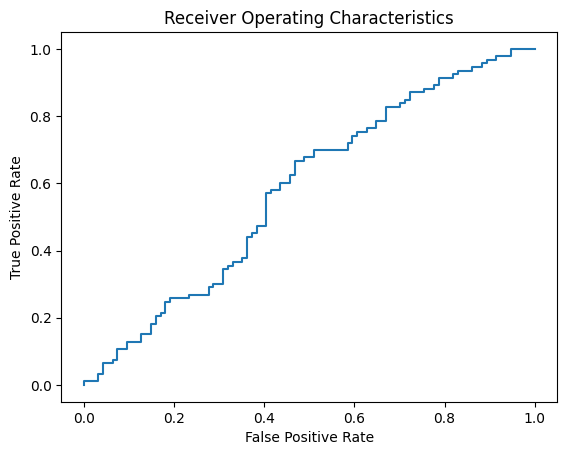

Depression
Accuracy (wide): 0.65
Accuracy (wide): 0.66
Accuracy (wide): 0.67
Accuracy (wide): 0.66
Accuracy (wide): 0.67
Model: 65.83% (+/- 0.74%)
Final model accuracy: 64.71%


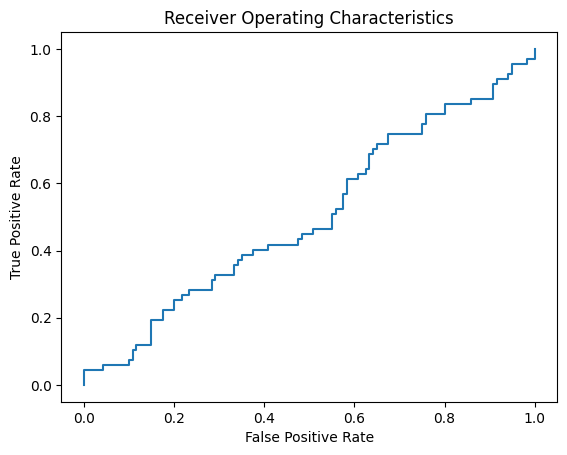

Insomnia
Accuracy (wide): 0.76
Accuracy (wide): 0.77
Accuracy (wide): 0.77
Accuracy (wide): 0.77
Accuracy (wide): 0.78
Model: 77.07% (+/- 0.64%)
Final model accuracy: 73.80%


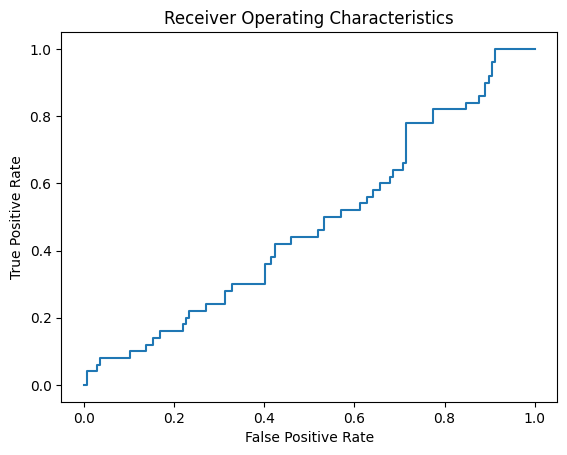

OCD
Accuracy (wide): 0.86
Accuracy (wide): 0.87
Accuracy (wide): 0.87
Accuracy (wide): 0.87
Accuracy (wide): 0.86
Model: 86.93% (+/- 0.53%)
Final model accuracy: 86.63%


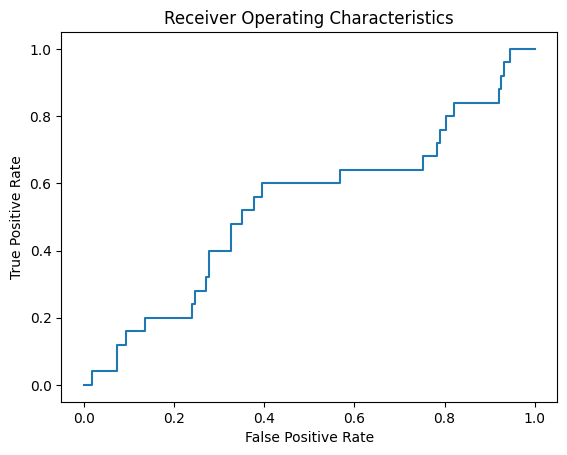

In [ ]:
size = len(x_columns)
layers = 10
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(size, size * layers)
        self.relu = nn.ReLU()
        self.output = nn.Linear(size * layers, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

# Helper function to train one model
def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 100   # number of epochs to run
    batch_size = 15  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

# train-test split: Hold out the test set for final model evaluation
for i in range(len(y_columns)):
  print(y_columns[i])
  y = df2[y_columns[i]].to_numpy()
  y = y[:, np.newaxis]
  XT= torch.tensor(X, dtype=torch.float32)
  yT = torch.tensor(y, dtype=torch.float32)
  X_train, X_test, y_train, y_test = train_test_split(XT, yT, train_size=0.7, shuffle=True)

  # define 5-fold cross validation test harness
  kfold = StratifiedKFold(n_splits=5, shuffle=True)
  cv_scores_wide = []
  for train, test in kfold.split(X_train, y_train):
      # create model, train, and get accuracy
      model = Model()
      acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
      print("Accuracy (wide): %.2f" % acc)
      cv_scores_wide.append(acc)

  # evaluate the model
  wide_acc = np.mean(cv_scores_wide)
  wide_std = np.std(cv_scores_wide)
  print("Model: %.2f%% (+/- %.2f%%)" % (wide_acc*100, wide_std*100))

  model = Model()
  acc = model_train(model, X_train, y_train, X_test, y_test)
  print(f"Final model accuracy: {acc*100:.2f}%")

  model.eval()
  with torch.no_grad():
      # Test out inference with 5 samples
      for i in range(5):
          y_pred = model(X_test[i:i+1])

      # Plot the ROC curve
      y_pred = model(X_test)
      fpr, tpr, thresholds = roc_curve(y_test, y_pred)
      plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
      plt.title("Receiver Operating Characteristics")
      plt.xlabel("False Positive Rate")
      plt.ylabel("True Positive Rate")
      plt.show()